In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

%config Completer.use_jedi = False

In [4]:
# downloaded from https://github.com/gulvarol/grocerydataset
annotation_path = '../dataset/grocerydataset-master'

In [5]:
cols = ["image_name", "x_1", "y_1", "x_2", "y_2", "b_i"]
master_df = pd.read_csv(os.path.join(annotation_path, "annotations.csv"), 
                        names=cols)
master_df.head()

,image_name,x_1,y_1,x_2,y_2,b_i
0,C1_P01_N1_S2_1.JPG,1008,1552,1260,1928,0
1,C1_P01_N1_S2_1.JPG,1028,928,1280,1304,0
2,C1_P01_N1_S2_1.JPG,24,872,268,1264,0
3,C1_P01_N1_S2_1.JPG,280,1568,532,1944,0
4,C1_P01_N1_S2_1.JPG,292,872,544,1248,0


In [6]:
master_df['b_i'].unique()

array([ 0,  1,  4,  7,  3,  6, 10,  2,  5,  8,  9])

### Finding the average Aspect Ratio

Since we can only have one anchor box per feature map cell, it's important to understand the aspect ratio distribution in the dataset 

In [7]:
master_df['ar'] = (master_df['x_2'] - master_df['x_1'])/(master_df['y_2'] - master_df['y_1'])
master_df.head()

,image_name,x_1,y_1,x_2,y_2,b_i,ar
0,C1_P01_N1_S2_1.JPG,1008,1552,1260,1928,0,0.670213
1,C1_P01_N1_S2_1.JPG,1028,928,1280,1304,0,0.670213
2,C1_P01_N1_S2_1.JPG,24,872,268,1264,0,0.622449
3,C1_P01_N1_S2_1.JPG,280,1568,532,1944,0,0.670213
4,C1_P01_N1_S2_1.JPG,292,872,544,1248,0,0.670213


(array([  5.,  22.,  77., 380., 857., 843., 433., 102.,  21.,   4.]),
 array([0.42056075, 0.47225467, 0.5239486 , 0.57564252, 0.62733645,
        0.67903037, 0.7307243 , 0.78241822, 0.83411215, 0.88580607,
        0.9375    ]),
 <BarContainer object of 10 artists>)

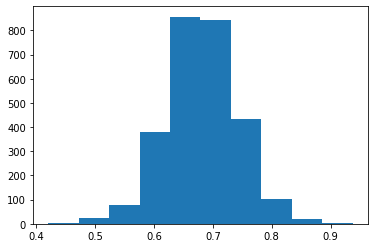

In [8]:
plt.hist(master_df.loc[master_df['b_i']!=0, 'ar'].values)

In [9]:
master_df['ar'].mean()

0.6589409662173765

In [10]:
master_df['ar'].std()

0.07013425480860264

In [12]:
master_df['ar'].value_counts()

0.666667    441
0.750000    137
0.714286    128
0.700000    114
0.647059    110
           ... 
0.616162      1
0.561983      1
0.534247      1
0.707547      1
0.495146      1
Name: ar, Length: 1285, dtype: int64

### Splitting the dataset

In [13]:
shelf_image_path = '../dataset/GroceryDataset_part1.tar-2/ShelfImages'
train_images = os.listdir(os.path.join(shelf_image_path, 'train'))
test_images = os.listdir(os.path.join(shelf_image_path, 'test'))

In [14]:
len(train_images)

283

In [15]:
len(test_images)

71

We want to split 10% of the training images for validation

In [16]:
len(train_images) * 0.1

28.3

In [17]:
random_images = np.random.choice(train_images,
                                 size=int(len(train_images) * 0.1),
                                 replace=False)

Before splitting the dataset, we should add the brand_ids by one since during training we'd want the background images to be labeled as 0.

In [19]:
master_df['b_i'] = master_df['b_i'] + 1
master_df.head()

,image_name,x_1,y_1,x_2,y_2,b_i,ar
0,C1_P01_N1_S2_1.JPG,1008,1552,1260,1928,1,0.670213
1,C1_P01_N1_S2_1.JPG,1028,928,1280,1304,1,0.670213
2,C1_P01_N1_S2_1.JPG,24,872,268,1264,1,0.622449
3,C1_P01_N1_S2_1.JPG,280,1568,532,1944,1,0.670213
4,C1_P01_N1_S2_1.JPG,292,872,544,1248,1,0.670213


In [20]:
train_df = master_df.loc[master_df['image_name'].isin(train_images)]
test_df = master_df.loc[master_df['image_name'].isin(test_images)]

In [21]:
val_df = train_df.loc[train_df['image_name'].isin(random_images)]
train_df = train_df.loc[~train_df['image_name'].isin(random_images)]

In [22]:
train_df.shape

(9553, 7)

In [23]:
val_df.shape

(983, 7)

In [24]:
test_df.shape

(2648, 7)

In [25]:
master_df.shape

(13184, 7)

In [ ]:
# train_df.to_csv(os.path.join(shelf_image_path, 'training_annotations_split.csc'), index=False)
# val_df.to_csv(os.path.join(shelf_image_path, 'validation_annotations_split.csc'), index=False)
# test_df.to_csv(os.path.join(shelf_image_path, 'testing_annotations_split.csc'), index=False)

### Identifying the weights for Loss function

In [29]:
master_df['b_i'].value_counts()

1     7646
3      649
5      292
2      240
8      214
9      147
7      130
6       79
10      62
11      50
4       44
Name: b_i, dtype: int64

Since the dataset is highly imbalanced, we'd like to weigh the loss function accordingly. We weigh each class by the reciprocal of it's frequency in the dataset

In [45]:
class_weights = (1/(master_df['b_i'].value_counts()/master_df.shape[0])).sort_index().to_dict()
class_weights

{1: 1.2628352490421457,
 2: 43.368421052631575,
 3: 13.210420841683366,
 4: 196.77611940298507,
 5: 32.0,
 6: 115.64912280701755,
 7: 69.38947368421053,
 8: 42.39228295819936,
 9: 67.61025641025641,
 10: 169.02564102564102,
 11: 175.78666666666666}

In [48]:
#normalizing the weights
weights = torch.tensor(list(class_weights.values()))
weights = (weights)/(weights.max().item() - weights.min().item())
weights

tensor([0.0065, 0.2218, 0.0676, 1.0065, 0.1637, 0.5915, 0.3549, 0.2168, 0.3458,
        0.8645, 0.8991])

In [50]:
weights = [w.item() for w in weights]
weights

[0.006459076423197985,
 0.22181826829910278,
 0.06756789237260818,
 1.00645911693573,
 0.16367173194885254,
 0.5915154218673706,
 0.3549092411994934,
 0.21682558953762054,
 0.3458090126514435,
 0.8645224571228027,
 0.8991034030914307]

In [51]:
dict(zip(range(1, 12), weights))

{1: 0.006459076423197985,
 2: 0.22181826829910278,
 3: 0.06756789237260818,
 4: 1.00645911693573,
 5: 0.16367173194885254,
 6: 0.5915154218673706,
 7: 0.3549092411994934,
 8: 0.21682558953762054,
 9: 0.3458090126514435,
 10: 0.8645224571228027,
 11: 0.8991034030914307}